/tmp/ipykernel_44143/3143995898.py:51: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch.append(numpy.array(image).squeeze())  # Convert to numpy and squeeze to (28, 28)


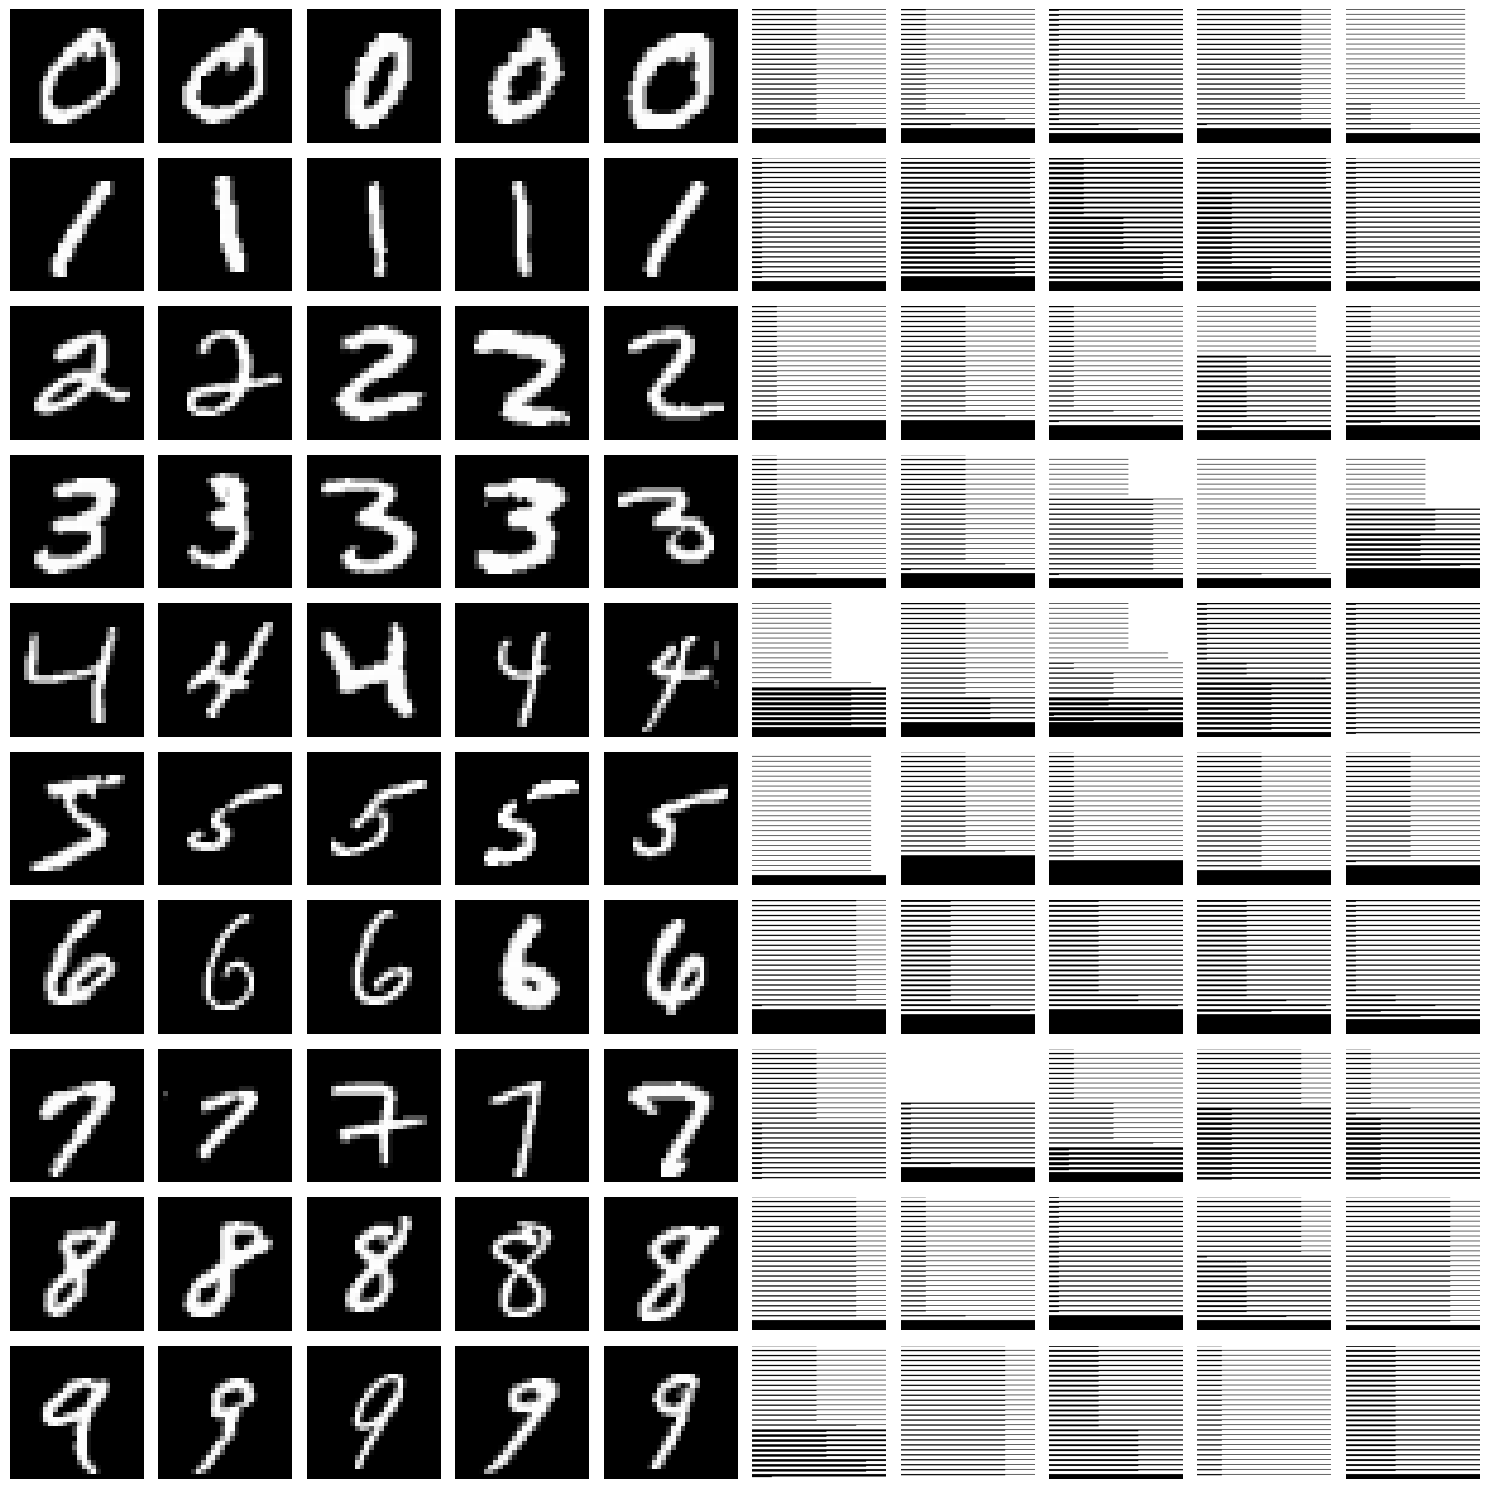

In [3]:
import torch
from torchvision import datasets, transforms
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy 
from aggregate_jax import jax_scan_aggregate  # Assuming this function is imported correctly

# Indexes per digit
digit_indices = {
    0: [1, 21, 34, 37, 51],
    1: [3, 6, 8, 14, 23],
    2: [5, 16, 25, 28, 76],
    3: [7, 10, 12, 27, 30],
    4: [2, 9, 20, 26, 53],
    5: [0, 11, 35, 47, 65],
    6: [13, 18, 32, 36, 39],
    7: [15, 29, 38, 42, 52],
    8: [17, 31, 41, 46, 55],
    9: [4, 19, 22, 33, 43]
}

# Load MNIST dataset without transform (for raw access)
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Container for final grid images
original_images = []
aggregated_images = []

n, p, q = 5, 3, 3

# Example parameters for aggregation, modify them according to your needs
params = {
    'a': jnp.ones((n,)),
    'b': jnp.ones((n,)),
    'b_prime': jnp.ones((n,)),
    'c': jnp.ones((n,)),
    'c_prime': jnp.ones((n,)),
    'd': jnp.ones((n,)), 
    'd_prime': jnp.ones((n,)),
    'e': jnp.ones((q,))
}

# Process each digit
for digit in range(10):
    indices = digit_indices[digit]
    batch = []

    for idx in indices:
        image, label = mnist_data.data[idx], mnist_data.targets[idx]
        batch.append(numpy.array(image).squeeze())  # Convert to numpy and squeeze to (28, 28)

    # Convert the batch to a JAX array (5, 28, 28)
    batch_jax = jnp.array(batch)

    # Call the aggregation function (make sure `jax_scan_aggregate` is defined correctly)
    agg_result = jax_scan_aggregate(n, p, q, batch_jax, params)  # Shape should be (rows, cols, batch_size, np, nq)

    # Reshaping logic to match (batch_size, rows * np, cols * nq)
    rows, cols, batch_size, np, nq = agg_result[-1].shape
    
    # Permute the axes to move the batch_size to the front and then reshape
    permuted = jnp.transpose(agg_result[-1], (2, 0, 1, 3, 4))  # (batch_size, rows, cols, np, nq)
    aggregate = permuted.reshape(batch_size, rows * np, cols * nq)  # (batch_size, rows*np, cols*nq)

    original_images.extend(batch)
    aggregated_images.extend(aggregate)

# Plotting 10x10 grid (5 originals + 5 aggregates for each digit)
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(10):
    for j in range(5):  # original images
        ax = axes[i, j]
        ax.imshow(original_images[i*5 + j], cmap='gray')
        ax.axis('off')
    for j in range(5):  # aggregated images
        ax = axes[i, j+5]
        ax.imshow(numpy.array(aggregated_images[i*5 + j]), cmap='gray')
        ax.axis('off')

plt.tight_layout()
plt.show()
